In [2]:
import numpy as np
import tensorflow as tf
#import matplotlib as plt
import cv2
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
import matplotlib.pyplot as plt
import pickle

2023-11-03 18:04:06.223046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

TESTIMAGE = ""
ANNOTATIONEN = ""
CLASSES = "category_index.pkl"

with open(CLASSES, 'rb') as file:
	category_index = pickle.load(file)


In [4]:
def load_image(path):
	image = cv2.imread("test1.jpg")

	height, width, channels = image.shape
	desired_size = 320
	if height > width:
		new_height = desired_size
		scale = desired_size / height
		new_width = int(scale * width)
	else:
		new_width = desired_size
		scale = desired_size / width
		new_height = int(scale * height)
	resized_image = cv2.resize(image, (new_width, new_height))

	padded_image = np.zeros((desired_size, desired_size, channels), dtype=np.uint8)
	top = (desired_size - new_height) // 2
	left = (desired_size - new_width) // 2
	padded_image[top:top + new_height, left:left + new_width] = resized_image
	padded_image = padded_image[..., ::-1]

	input_tensor = tf.convert_to_tensor(padded_image)
	input_tensor = input_tensor[tf.newaxis, ...]

	return (padded_image, input_tensor)

In [5]:
def drawboxes(image, detection_boxes, detection_classes, detection_scores):
	"""
	displays the image & classification bounds, invoked by render argument in testModel()
	:param image: automatically acquired from argument test_image_path from testModel()
	:param detection_boxes: 
	:param detection_classes: 
	:param detection_scores: 
	"""
	IMAGE_SIZE = (6, 4)

	image_copy = np.copy(image)
	desired_size = (image_copy.shape[1] * 4, image_copy.shape[0] * 4)

	enlarged_image = cv2.resize(image_copy, desired_size)
	viz_utils.visualize_boxes_and_labels_on_image_array(
		enlarged_image,
		detection_boxes[0],
		detection_classes[0].astype(int),
		detection_scores[0],
		category_index,
		use_normalized_coordinates=True,
		max_boxes_to_draw = 200,
		min_score_thresh = .4, # Adjust this value to set the minimum probability boxes to be classified as True
		agnostic_mode = False)
	%matplotlib inline
	plt.figure(figsize=IMAGE_SIZE, dpi=200)
	plt.axis("off")
	plt.imshow(enlarged_image)
	plt.show()

In [6]:
def testModel(model_path, test_image_path, render=False):
	"""
	:param model_path: `str` location of .tflite model
	:param test_image_path: `str` location of image
	:param render: `bool` option to draw image with its bounding boxes
	"""

	interpreter = tf.lite.Interpreter(model_path=model_path)

	input_details = interpreter.get_input_details()
	output_details = interpreter.get_output_details()

	new_input_shape = (1, 320, 320, 3)  # Neue Eingabegröße: (Batch, Höhe, Breite, Kanäle)
	interpreter.resize_tensor_input(input_details[0]['index'], new_input_shape)
	interpreter.resize_tensor_input(output_details[0]['index'], new_input_shape)

	interpreter.allocate_tensors()

	image, input_tensor = load_image(test_image_path)

	interpreter.set_tensor(input_details[0]['index'], input_tensor)

	interpreter.invoke()

	output_details = interpreter.get_output_details()

	detection_boxes = interpreter.get_tensor(output_details[4]['index'])
	detection_classes = interpreter.get_tensor(output_details[5]['index'])
	detection_scores = interpreter.get_tensor(output_details[6]['index'])

	if render:
		drawboxes(image, detection_boxes, detection_classes, detection_scores)



In [10]:
testModel("model32.tflite", "test1.jpg", True)

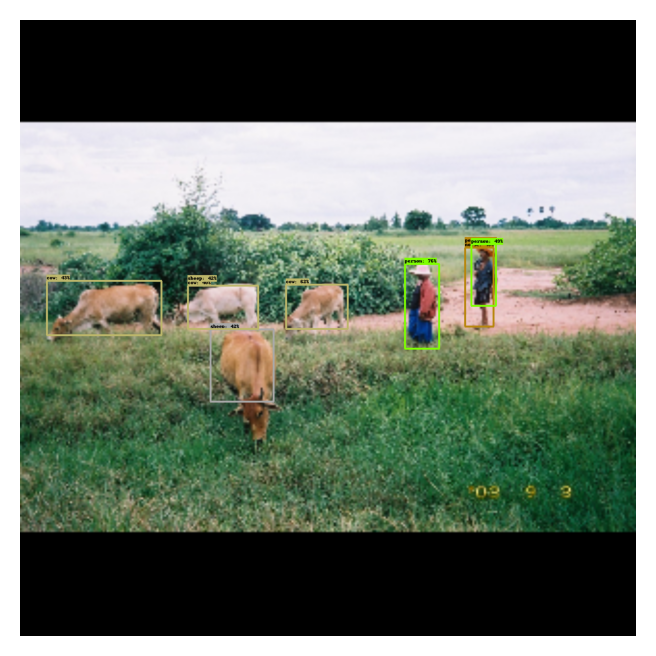

In [8]:
testModel("model16.tflite", "test1.jpg", True)

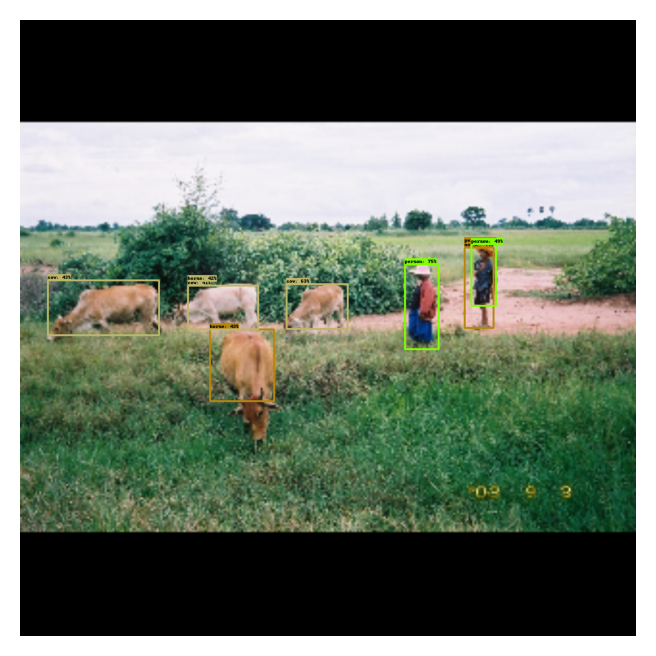

In [9]:
testModel("model8.tflite", "test1.jpg", True)